In [24]:
from datetime import datetime

import torch

import util
from Dimploma.EnvironmentTree import EnvMinimalTreeTwoStep, EnvMinimalTreeTwoStepRew, EnvMaximalTreeTwoStepHeur, \
    EnvMaximalTreeTwoStep, EnvMinimalTreeTwoStepHeur, MatrixEnvInfo, EnvInfo
from Dimploma.ppo_parallel_custom import Agent
from Dimploma.utils.graph_provider import GraphProvider
from Dimploma.zNetwork.my_gcn import GCN
from Dimploma.zNetwork.fully_con import FCN

In [2]:
%load_ext autoreload
%autoreload 2

device:  cpu
Loading graph


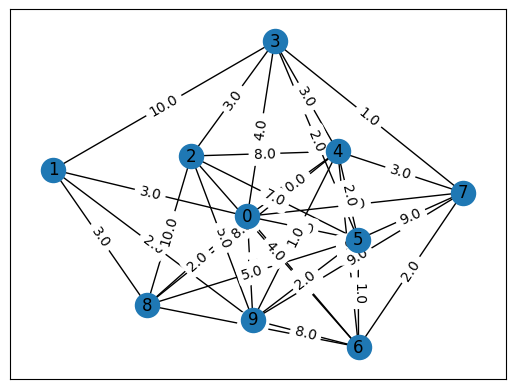

Name: n10_e33_g42_mn_2-2_s
Desc: 
Training comment:
Trying to test out matrix repr with fully connected layers

Increased the step amount

Trying out training with:

Training
Iterations: 1000
Epochs: 4
Batch size: 576
Steps amount: 36
Count of processes: 16
Count of envs: 4
On device: cpu
without early stopping


Network:
Main layers: 2
P layers: 2
V layers: 2
without catenation between layers

Environment:
Class: EnvMinimalTreeTwoStepHeur
Loaded graph from graphs/graph42_n10_e33_heur_rew2.pt
Matrix representation
Node amount: 10
Edge amount: 33
Node features: 2
When graph representation is used
With indexes in nodes

When matrix representation is used
Observation consistt of:

Selected edge info
Selected node info


Parameters:
Gamma: 0.99
Epsilon: 0.3
Coef_value: 0.5
Coef_Entropy: 0.002
Gae_lambda: 0.95
Learning rate: 0.00025

tensor([[0, 0, 8, 0, 5, 0, 5, 3, 8, 0, 6, 4, 9, 6, 1, 5, 2, 6, 3, 4, 4, 4, 1, 5,
         4, 7, 6, 9, 5, 2, 4, 5, 1],
        [7, 8, 5, 3, 4, 1, 9, 2, 6, 9, 9,

In [28]:
node_amount = 10
max_edge_amount = torch.sum(torch.arange(node_amount)).item()
edge_amount = int(max_edge_amount*0.75)
iteration_amount = 1000
epoch_amount = 4 # 5-6 is the best, bigger batch size is better
batch_size = 576
node_features = 2  # (index, {0,1} selected or not)
steps_amount = int((node_amount - 1)*2) * 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device: ', device)

count_of_processes = 16
count_of_envs = 4

in_tree_rewards = False
heur_rewards = True
max_tree = False

fully_connected = True
use_matrix = False
edge_info = True
node_info = True
step_info = False

early_stop = False
position = False
remove_index = False
if position:
    node_features += 2
if remove_index:
    node_features -= 1

cat_in_net = False
main_layers = 2
p_layers = 2
v_layers = 2


gamma=0.99
epsilon=0.3
coef_value=0.5
coef_entropy=0.002
gae_lambda=0.95
lr=0.00025


fixed_graph = True
# load_graph = 'results/min_tree_ppo/node/241217_15#n10_e45_cat_part2/graph.pt'
# load_graph = 'graphs/graph2_norm.pt'
# load_graph = 'graphs/graph5_n50_norm.pt'
load_graph = 'graphs/graph42_n10_e33_heur_rew2.pt'
# load_graph = ''
save_new = ''
# save_new = f'graphs/graph42_n{node_amount}_e{edge_amount}_heur_rew2.pt'
# load_from = 'results/min_tree_ppo/node/241217_15#n10_e45_cat_part2/models/iter_499_last.pt'
# load_from = 'results/min_tree_ppo/node/250103_18#n10_e45_not_fixed/models/iter_999_last.pt'
load_from = ''
graph = None

if load_graph != '':
    print('Loading graph')
    graph = torch.load(load_graph, weights_only=False)
    util.show_data(graph)
elif fixed_graph:
    print('Fixing graph')
    graph = util.generate_random_graph_add_method(node_amount, edge_amount, device=device, position=position)
    if save_new != '':
        print('Saving graph')
        torch.save(graph, save_new)
    util.show_data(graph)

graph_provider = GraphProvider(fixed_graph=graph, device=device, nodes=node_amount, edges=edge_amount, position=position)


name = f'n{node_amount}_e{edge_amount}_g42_mn_2-2_s'

training_desc = f'''
Training comment:
Trying to test out matrix repr with fully connected layers

Increased the step amount

Trying out training with:

Training
Iterations: {iteration_amount}
Epochs: {epoch_amount}
Batch size: {batch_size}
Steps amount: {steps_amount}
Count of processes: {count_of_processes}
Count of envs: {count_of_envs}
On device: {device}
{'with' if early_stop else 'without'} early stopping


Network:
Main layers: {main_layers}
P layers: {p_layers}
V layers: {v_layers}
{'with' if cat_in_net else 'without'} catenation between layers

Environment:
Class: {f'EnvMinimalTreeTwoStepRew' if in_tree_rewards else f'EnvMinimalTreeTwoStepHeur' if heur_rewards else f'EnvMinimalTreeTwoStep'}
{f'Loaded graph from {load_graph}' if load_graph != '' else 'Fixed graph' + (f' saved  as {save_new}' if save_new != '' else '') if fixed_graph else f'Random generated graphs'}
{'Matrix representation' if fully_connected else 'Graph representation'}
Node amount: {node_amount}
Edge amount: {edge_amount}
Node features: {node_features}
When graph representation is used
{'Without indexes in nodes' if remove_index else 'With indexes in nodes'}
{'With positions' if position else ''}
When matrix representation is used
Observation consistt of:
{'Adjacency matrix' if use_matrix else ''}
{'Selected edge info' if edge_info else ''}
{'Selected node info' if node_info else ''}
{'Step info' if step_info else ''}

Parameters:
Gamma: {gamma}
Epsilon: {epsilon}
Coef_value: {coef_value}
Coef_Entropy: {coef_entropy}
Gae_lambda: {gae_lambda}
Learning rate: {lr}
'''

path = 'results/min_tree_ppo/node/'
last_path = f'models/iter_{iteration_amount - 1}_last.pt'
print("Name:", name)
print("Desc:", training_desc)
if fixed_graph:
    print(graph.edge_index, '\n', graph.edge_attr, '\n', graph.edge_weight, '\n', graph.x)

In [29]:
last_name = "fuckup"

In [30]:
start_date = datetime.now()

try:
    # noinspection PyUnresolvedReferences
    if last_name == name:
        raise Exception("You should change the name :D")
except NameError:
    raise Exception("You should init last name :D")

if training_desc == '':
    raise Exception("You should write a nice description :D")

last_name = name

if fully_connected:
    net = FCN(node_amount, node_features, edge_amount, main_layers, p_layers, v_layers, edge_info, node_info, step_info, use_matrix)
else:
    net = GCN(node_amount, node_features, cat_in_net, main_layers, p_layers, v_layers, remove_index=remove_index, position=position)

print(f'Agent {name}')

agent = Agent(model=net, gamma=gamma, epsilon=epsilon, coef_value=coef_value, coef_entropy=coef_entropy, gae_lambda=gae_lambda, lr=lr, device=device, path=path, name=name, override=True, early_stop=early_stop)
# agent = Agent(model=net, device=device, path=path, name=name, override=True)

if load_from != '':
    agent.load_model(load_from)

env = EnvMinimalTreeTwoStep
if max_tree:
    if heur_rewards:
        env = EnvMaximalTreeTwoStepHeur
    else:
        env = EnvMaximalTreeTwoStep
else:
    if heur_rewards:
        env = EnvMinimalTreeTwoStepHeur
    elif in_tree_rewards:
        env = EnvMinimalTreeTwoStepRew


env_info = EnvInfo(graph_provider)
if fully_connected:
    env_info = MatrixEnvInfo(graph_provider, edge_info, node_info, step_info, use_matrix)

agent.training_description(training_desc)
training_desc = ''
# agent.train([device, None, node_amount, edge_amount], EnvMinimalTreeTwoStep, node_amount, count_of_processes=1, count_of_envs=1, batch_size=32, count_of_iterations=iteration_amount)
agent.train([env_info], env, node_amount, count_of_iterations=iteration_amount, count_of_epochs=epoch_amount, batch_size=batch_size, count_of_steps=steps_amount, count_of_processes=count_of_processes, count_of_envs=count_of_envs)


end_date = datetime.now()
torch.save(graph, agent.path + '/graph.pt')
s = (end_date - start_date).seconds
hours, remainder = divmod(s, 3600)
minutes, seconds = divmod(remainder, 60)
#-1.42077
print(f'Time training {int(hours):02}:{int(minutes):02}:{int(seconds):02}')

Agent n10_e33_g42_mn_2-2_s
Training is starting
Iteration 0 starting
Iteration 0	episode 100	avg score -0.97629	best score 0.62857	best avg score -0.97629
Iteration 1 starting
Iteration 1	episode 200	avg score -0.95600	best score 0.87143	best avg score -0.95600
Iteration 2 starting
Iteration 2	episode 300	avg score -0.94814	best score 0.87143	best avg score -0.94814
Iteration 3 starting
Iteration 3	episode 400	avg score -0.96114	best score 0.87143	best avg score -0.94814
Iteration 4 starting
Iteration 4	episode 500	avg score -0.98243	best score 0.87143	best avg score -0.94814
Iteration 5 starting
Iteration 5	episode 600	avg score -0.95214	best score 0.87143	best avg score -0.94814
Iteration 6 starting
Iteration 6	episode 700	avg score -0.84771	best score 0.87143	best avg score -0.84771
Iteration 7 starting
Iteration 7	episode 800	avg score -0.85614	best score 0.87143	best avg score -0.84771
Iteration 8 starting
Iteration 8	episode 900	avg score -0.77257	best score 0.87143	best avg scor